# Fitting Single Gaussian's to Spectra, HC$_5$N (9-8)

In [98]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt
import moment as m
from scipy.optimize import curve_fit
from scipy import stats

## Initalizing data and functions

In [22]:
hdul = fits.open('/Users/simonsmith/Documents/SURP/HC2/HC2_HC5N_all_rebase3_trim.fits')
head = hdul[0].header
data = hdul[0].data

In [23]:
head

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  330                                                  
NAXIS2  =                  524                                                  
NAXIS3  =                  334                                                  
BUNIT   = '' / Tmb                                                              
INSTRUME= 'KFPA    '                                                            
BMAJ    = 0.008458002825349066                                                  
BMIN    = 0.008458002825349066                                                  
BPA     =                  0.0                                                  
TELESCOP= 'GBT     '                                                            
WCSAXES =                   

In [24]:
x_pix, y_pix, z_pix = head['NAXIS1'], head['NAXIS2'], head['NAXIS3']
x_deg, y_deg = x_pix*head['CDELT1']*u.deg, y_pix*head['CDELT2']*u.deg

x_pc, y_pc = (x_deg.to(u.rad)*140*u.pc)/u.rad, (y_deg.to(u.rad)*140*u.pc)/u.rad
x_au, y_au = x_pc.to(u.au), y_pc.to(u.au)

d_freq = head['CDELT3']*u.Hz
d_v = (c.c*(d_freq/(head['RESTFRQ']*u.Hz))).to(u.m/u.s)

rad_v = []
freqs = []
for i in range(z_pix):
    freq = head['CRVAL3']*u.Hz - (i-head['CRPIX3'])*d_freq
    freqs.append(freq/u.Hz)
    rad_v.append((c.c*(1 - freq/(head['RESTFRQ']*u.Hz))).to(u.m/u.s)/(u.m/u.s))
    
rad_v = np.asarray(rad_v)
freqs = np.asarray(freqs)

def gauss(x, amp, cen, wid):
    if wid == 0:
        wid = 1
    else:
        wid = wid
        
    return amp * np.exp(-(x-cen)**2 / wid)

In [89]:
def fit_g(data, rad_v, x, y, wid_guess = 1e5, std = 0):
    """
    Fit single gaussian to one spectra, specified by pixel
    
    Parameters:
    
    data - 3d array
    rad_v - array
    x, y - int
    
    Returns:
    
    amp - float
    cen - float
    wid - float
    
    """
    
    spec = m.int_pix(data, x, y)
    sig = np.full((spec.shape), std)
    
    init_vals = [np.max(spec), rad_v[np.where(spec == np.max(spec))[0][0]], wid_guess] # for [amp, cen, wid]
    try:
        best_vals, covar = curve_fit(gauss, rad_v, spec, p0=init_vals, sigma=sig)
    except RuntimeError:
        best_vals = [0, 0, 1]
    amp, cen, wid = best_vals
    
    
    return amp, cen, wid

### Some first fits

In [5]:
spec = m.int_pix(data, 60, 180)


In [6]:
#Based on Frequency
init_vals = [np.max(spec), freqs[np.where(spec == np.max(spec))[0][0]], 1e9]  # for [amp, cen, wid]
best_vals, covar = curve_fit(gauss, freqs, spec, p0=init_vals)
print('best_vals: {}'.format(best_vals))

best_vals: [2.21791099e+00 2.39634297e+10 3.46194663e+08]


In [7]:
#Based on Velocity
init_vals1 = [np.max(spec), rad_v[np.where(spec == np.max(spec))[0][0]], 1e5]  # for [amp, cen, wid]
best_vals1, covar1 = curve_fit(gauss, rad_v, spec, p0=init_vals1)
print('best_vals: {}'.format(best_vals1))

best_vals: [2.21776571e+00 5.89654122e+03 5.41932324e+04]


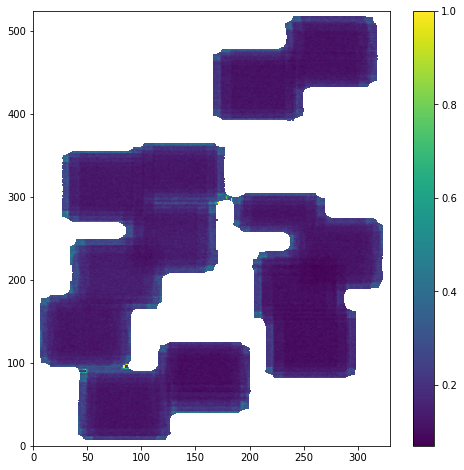

In [36]:
all_std = np.std(data[:150], axis=0)

plt.figure(figsize=(8,8))
plt.pcolormesh(all_std, vmax=1)
plt.colorbar()
plt.show()

### Finding Pixels with a valid maximum / peak

In [8]:
#Check if maximum value of one spectra is greater than 3 std's

spec = m.int_pix(data, 70, 65)
spec_std = np.std(spec)
np.max(spec) > 3*spec_std

True

In [203]:
#Create array Maximum (shape = 524, 330) that knows if maximum value in the spectrum
# of that pixel is greater than 3 std's of the given spectrum
std = np.std(data, axis=0)
maximum = np.zeros(std.shape)
for i in range(0, data.shape[2]):
    for j in range(0, data.shape[1]):
        spec = m.int_pix(data, i, j)
        maximum[j][i] = (np.max(spec) > 4*std[j][i])

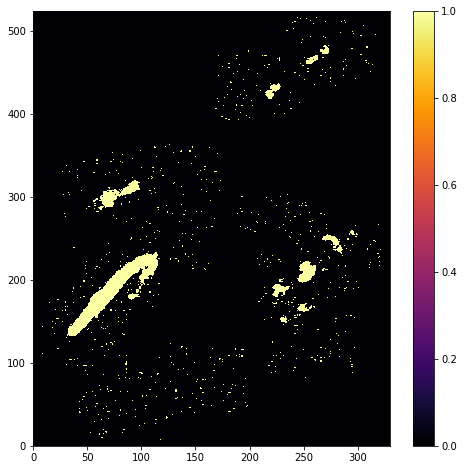

In [204]:
plt.figure(figsize=(8,8))
plt.pcolormesh(maximum, cmap='inferno')
plt.colorbar()
#plt.xlim([50, 100])
#plt.ylim([50, 100])
plt.show()

### Fit Single Gaussian for every pixel

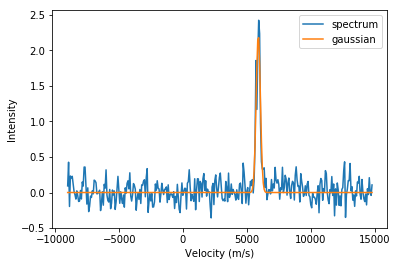

In [179]:
amp, cen, wid = fit_g(data, rad_v, 60, 180, std=all_std[180][60])
spec = m.int_pix(data, 60, 180)
plt.plot(rad_v, spec, label='spectrum')
plt.plot(rad_v, gauss(rad_v, amp, cen, wid), label='gaussian')
plt.legend()
plt.ylabel('Intensity')
plt.xlabel('Velocity (m/s)')
plt.show()

In [180]:
amps = np.zeros(maximum.shape)
cens = np.zeros(maximum.shape)
wids = np.ones(maximum.shape)

for i in range(0, maximum.shape[1]):
    for j in range(0, maximum.shape[0]):

        if maximum[j][i] == 1:
            amp, cen, wid = fit_g(data, rad_v, i , j, std=all_std[j][i])
            amps[j][i] = amp
            cens[j][i] = cen
            wids[j][i] = wid
        else:
            continue

/Users/simonsmith/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:466: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/Users/simonsmith/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in multiply


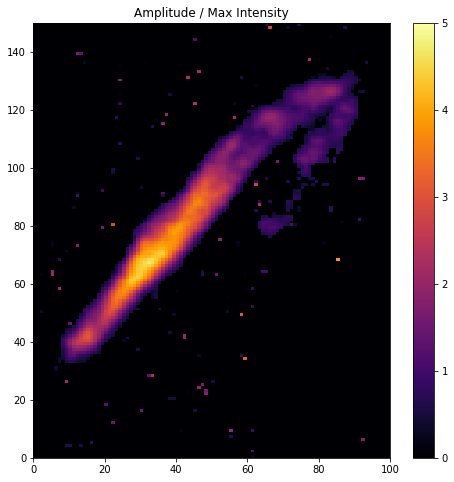

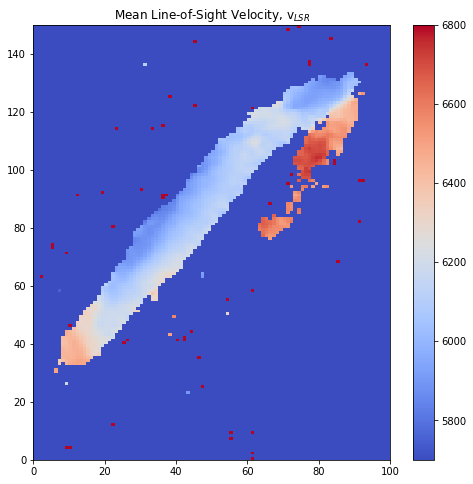

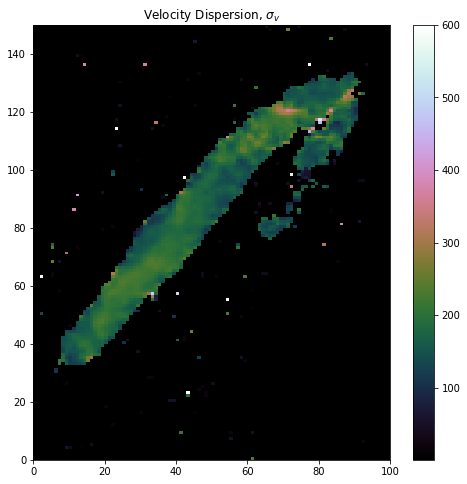

In [207]:
x1, x2, y1, y2 = 25, 125, 100, 250

plt.figure(figsize=(8,8))
plt.pcolormesh(amps[y1:y2, x1:x2], vmax = 5, cmap='inferno')
plt.colorbar()
plt.title('Amplitude / Max Intensity')
plt.show()
plt.figure(figsize=(8,8))
plt.pcolormesh(cens[y1:y2, x1:x2], vmax=6.8e3, vmin=5.7e3, cmap='coolwarm')
plt.colorbar()
plt.title('Mean Line-of-Sight Velocity, v$_{LSR}$')
plt.show()
plt.figure(figsize=(8,8))
plt.pcolormesh(np.sqrt(wids/2)[y1:y2, x1:x2], vmax = 600, cmap='cubehelix')
plt.colorbar()
plt.title('Velocity Dispersion, $\sigma_v$')
plt.show()


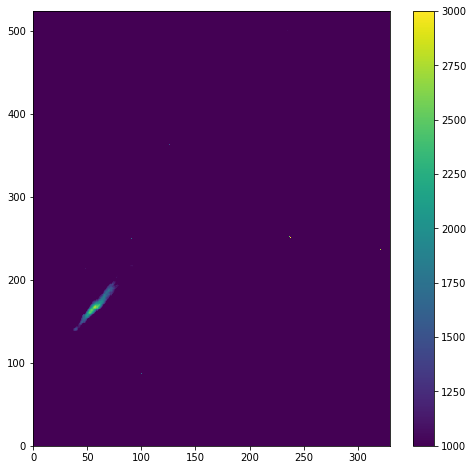

In [182]:
plt.figure(figsize=(8,8))
plt.pcolormesh(amps*np.sqrt(wids*np.pi), vmax = 3e3, vmin = 1e3)
plt.colorbar()
plt.show()

In [183]:
M_1 = m.first(data[190:220], rad_v[190:220])
M_2 = m.second(data[190:220], rad_v[190:220], M_1)

/Users/simonsmith/Documents/SURP/Main/moment.py:71: RuntimeWarning: invalid value encountered in sqrt
  M_2[i][j] = np.sqrt(np.dot((rad_v-M_1.T[i][j])**2, spec)/np.sum(spec))


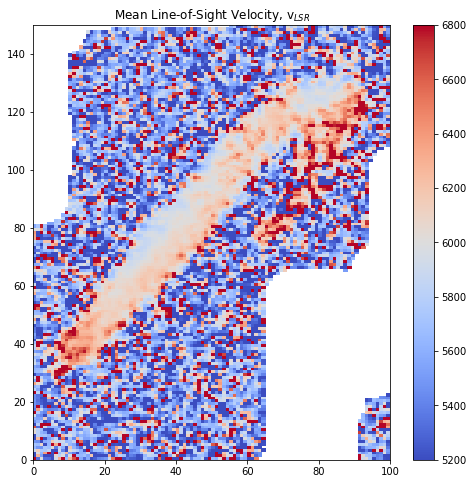

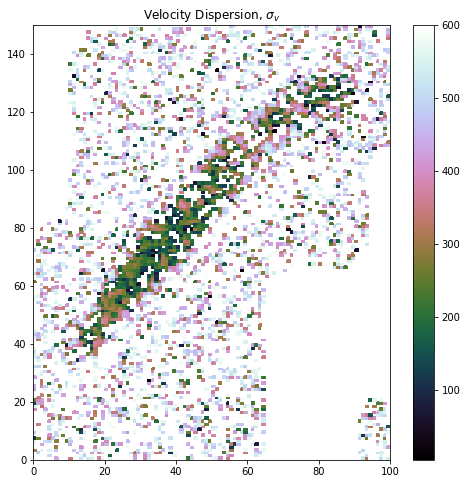

In [198]:
plt.figure(figsize=(8,8))
plt.pcolormesh(M_1[100:250, 25:125], vmax=6.8e3, vmin=5.2e3, cmap='coolwarm')
plt.colorbar()
plt.title('Mean Line-of-Sight Velocity, v$_{LSR}$')
plt.show()
plt.figure(figsize=(8,8))
plt.pcolormesh(M_2[100:250, 25:125], vmax = 600, cmap='cubehelix')
plt.colorbar()
plt.title('Velocity Dispersion, $\sigma_v$')
plt.show()


### Determining validity of Gaussian Fit

2.422724821902291 0.8591402175829665
best_vals: [2.21776571e+00 5.89654122e+03 5.41932324e+04]


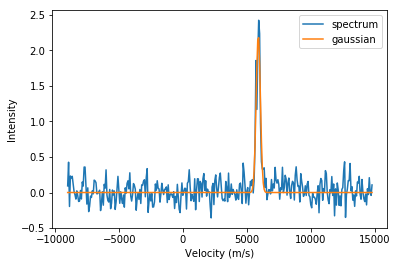

The column density is: 915.089, the mean velocity is: 5896.541 m / s, the velocity dispersion is: 164.610 m / s


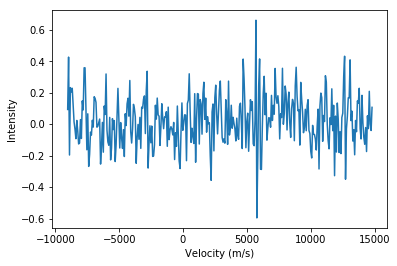

0.012079570685978341

In [185]:
spec = m.int_pix(data, 60, 180)
plt.plot(rad_v, spec, label='spectrum')
print(np.max(spec), 3*np.std(spec))

init_vals1 = [np.max(spec), rad_v[np.where(spec == np.max(spec))[0][0]], 1e5]  # for [amp, cen, wid]
try:
    best_vals1, covar1 = curve_fit(gauss, rad_v, spec, p0=init_vals1)
except RuntimeError:
    best_vals1 = [0, 0, 1]
print('best_vals: {}'.format(best_vals1))



amp, cen, wid = best_vals1
plt.plot(rad_v, gauss(rad_v, best_vals1[0], best_vals1[1], best_vals1[2]), label='gaussian')
plt.legend()
plt.ylabel('Intensity')
plt.xlabel('Velocity (m/s)')
plt.show()

density = amp*np.sqrt(np.pi*wid)
mean = cen*u.m/u.s
dispersion = np.sqrt(wid/2)*u.m/u.s

print("The column density is: {0:.3f}, the mean velocity is: {1:.3f}, the velocity dispersion is: {2:.3f}".format(density, mean, dispersion))


plt.plot(rad_v, spec - gauss(rad_v, best_vals1[0], best_vals1[1], best_vals1[2]))
plt.ylabel('Intensity')
plt.xlabel('Velocity (m/s)')
plt.show()

np.abs(np.std(spec[:150]) - np.std(spec - gauss(rad_v, best_vals1[0], best_vals1[1], best_vals1[2])))

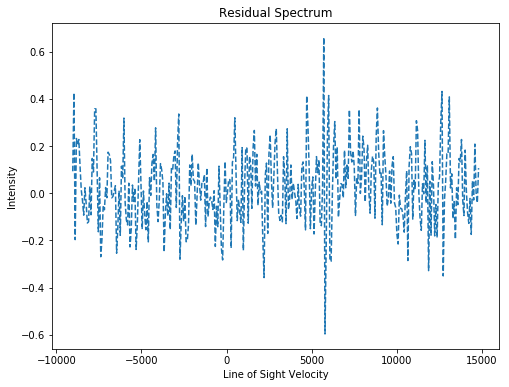

The residual deviations are: 0.012079570683285579


In [186]:
x, y = 60, 180
spec = m.int_pix(data, x, y)
fit = gauss(rad_v, amps[y][x], cens[y][x], wids[y][x])
resid = spec - fit
diff = np.abs(all_std[y][x] - np.std(resid))

plt.figure(figsize=(8,6))
plt.plot(rad_v, resid, '--')
plt.title('Residual Spectrum')
plt.xlabel('Line of Sight Velocity')
plt.ylabel('Intensity')
plt.show()

print('The residual deviations are: '+str(diff))

In [187]:
residuals = np.zeros(all_std.shape)
for i in range(0, residuals.shape[1]):
    for j in range(0, residuals.shape[0]):
        
        spec = m.int_pix(data, i, j)
        fit = gauss(rad_v, amps[j][i], cens[j][i], wids[j][i])
        resid = spec - fit
        diff = np.abs(all_std[j][i] - np.std(resid))
        
        residuals[j][i] = diff

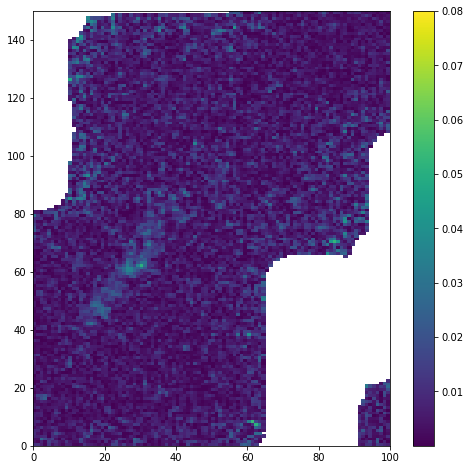

In [208]:
plt.figure(figsize=(8,8))
plt.pcolormesh(residuals[y1:y2, x1:x2], vmax = 0.08)
plt.colorbar()
plt.show()

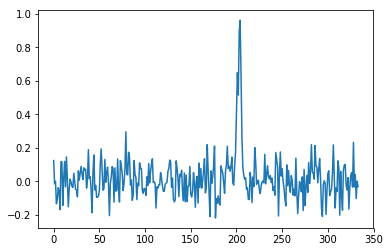

In [145]:
spec2 = m.int_pix(data, 250, 200)
plt.plot(spec2)

### Fitting with uncertainties

best_vals: [2.21776571e+00 5.89654122e+03 5.41932324e+04]
best_vals: [2.21776572e+00 5.89654122e+03 5.41932322e+04]


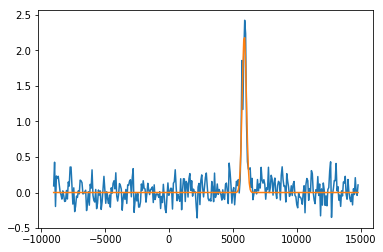

In [44]:
spec2 = m.int_pix(data, 60, 180)
plt.plot(rad_v, spec2)
#plt.plot(rad_v, gauss(rad_v, np.max(spec2), rad_v[np.where(spec2 == np.max(spec2))[0][0]], 1e5))

sig = np.full((spec.shape), all_std[180][60])

init_vals2 = [np.max(spec2), rad_v[np.where(spec2 == np.max(spec2))[0][0]], 1e5]  # for [amp, cen, wid]
best_vals2, covar2 = curve_fit(gauss, rad_v, spec2, p0=init_vals2)
best_vals3, covar3 = curve_fit(gauss, rad_v, spec2, p0=init_vals2, sigma=sig)
print('best_vals: {}'.format(best_vals2))
print('best_vals: {}'.format(best_vals3))

plt.plot(rad_v, gauss(rad_v, best_vals2[0], best_vals2[1], best_vals2[2]), label='gaussian')
plt.show()



### Histograms

In [165]:
cens_list = np.ravel(cens)
wids_list = np.sqrt(np.ravel(wids)/2)

cens_list[cens_list != 0]

array([ 5384.63431323, -7856.97919634, -2589.24334743, ...,
        7533.79432756, -6056.79259486, -7068.11288023])

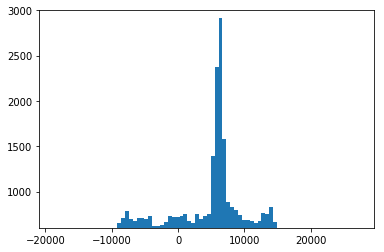

In [171]:
plt.hist(cens_list[cens_list != 0], bins='auto')
plt.ylim([600, 3000])
plt.show()

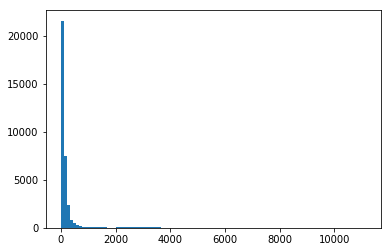

In [174]:
plt.hist(wids_list[wids_list != np.sqrt(1/2)], bins=100)
plt.show()

In [11]:
np.where(spec == np.max(spec))[0][0]

209

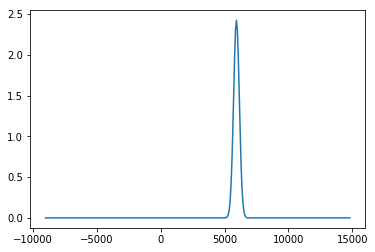

In [12]:
plt.plot(rad_v, gauss(rad_v, np.max(spec), rad_v[np.where(spec == np.max(spec))[0][0]], 1e5))

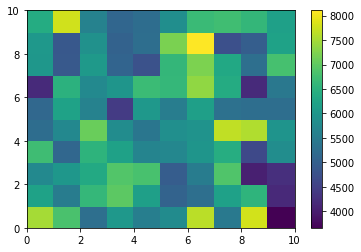

In [18]:
subset = data.T[55:65, 165:175].T

plt.pcolormesh(m.first(subset, rad_v))
plt.colorbar()
plt.show()

subset.shape

sub_spec = m.int_pix(subset, 2, 3)



In [39]:
all_std[180][60]

0.14688494742422306